<a href="https://www.kaggle.com/code/ffaraz/predictive-modeling-for-mpg-estimation?scriptVersionId=227317407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fuel-economy/database.csv


# 1- Objective
**Faraz A — 2025**

***

Understanding and improving vehicle fuel efficiency is a critical objective in the automotive industry, as it directly influences economic savings, environmental sustainability, and energy conservation. The U.S. Environmental Protection Agency (EPA) has played a pivotal role in providing comprehensive data on vehicle fuel economy through its publicly available "Vehicle Fuel Economy Estimates" dataset. This dataset encompasses crucial variables such as vehicle attributes, engine specifications, and fuel types, offering a rich source of information for analysis.

In this work we are trying to estimate a fuel efficiency of a vehicle based on available features of a car. We use fuel economy as the criteria here as is the distance travelled per unit volume of fuel used; we use miles per gallon (MPG) for this purpose (https://en.wikipedia.org/wiki/Fuel_economy_in_automobiles). Moreover, we aim to determine what are the most important factors in predicting MPG.



# 2- Data Description
***
We use the EPA dataset of Vehicle Fuel Economy Estimates, 1984-2017 available at https://www.kaggle.com/datasets/epa/fuel-economy.

Most vehicles in the database (other than plug-in hybrids) have three fuel economy estimates: a “city” estimate that represents urban driving, in which a vehicle is started in the morning (after being parked all night) and driven in stop-and-go traffic; a “highway” estimate that represents a mixture of rural and interstate highway driving in a warmed-up vehicle, typical of longer trips in free-flowing traffic; and a “combined” estimate that represents a combination of city driving (55%) and highway driving (45%). Estimates for all vehicles are based on laboratory testing under standardized conditions to allow for fair comparisons. We choose the combined value as the target metric for our work.

Let's start by reading the data:

In [5]:
df0 = pd.read_csv('/kaggle/input/fuel-economy/database.csv')

Let's only focus on a few parameters from this dataset. As mentioned, "combined" MPG is the target of this analysis so we choose that. We also select a few parameters that logically seem to be good predictors: year, number of cylinders, fuel type and the drive train.

In [6]:
df = df0[['Year','Engine Cylinders', 'Fuel Type','Drive','Combined MPG (FT1)']]

The distribution between some of the features and outcome are shown in the figures below:

In [18]:
#df.Year.hist()

In [19]:
#df['Combined MPG (FT1)'].hist()

# 3- Data Cleaning and Transformation
***

## 3-1- Simplify the data

Let's start by simplifying the fuel type:
- Any vehicles that uses gas or combination of it with another petroleum-based fuels are categorized as Gas.
- Any vehicles with a cmbination of gas and electricity, are categorized as Hybrid

In [7]:
df['Fuel Type'].unique()

array(['Regular', 'Diesel', 'Premium', 'CNG', 'Electricity',
       'Gasoline or natural gas', 'Gasoline or E85',
       'Gasoline or propane', 'Premium or E85',
       'Premium Gas or Electricity', 'Midgrade',
       'Regular Gas and Electricity', 'Premium and Electricity',
       'Regular Gas or Electricity'], dtype=object)

In [8]:
df.loc[df['Fuel Type'].isin(['Gasoline or natural gas', 'Gasoline or E85','Gasoline or propane',
                             'Premium','Premium or E85','Midgrade','Regular']),'Fuel Type'] = 'Gas'

In [9]:
df.loc[df['Fuel Type'].isin(['Premium Gas or Electricity', 'Regular Gas and Electricity',
                             'Premium and Electricity', 
                             'Regular Gas or Electricity']),'Fuel Type'] = 'Hybrid'

For the drive train, anything with all or 4-wheel is categorized as '4-Wheel or All-Wheel Drive'.

In [10]:
df.loc[df['Drive'].isin([ '4-Wheel or All-Wheel Drive','4-Wheel Drive',
                         'All-Wheel Drive', 
                         'Part-time 4-Wheel Drive']),'Drive'] = '4-Wheel or All-Wheel Drive'

## 3-2- Fill nan values

Fill the nan values with the most common values for each column.

In [11]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [12]:
df.head()

,Year,Engine Cylinders,Fuel Type,Drive,Combined MPG (FT1)
0,1984,6.0,Gas,Front-Wheel Drive,20
1,1984,6.0,Gas,Front-Wheel Drive,20
2,1984,4.0,Gas,Front-Wheel Drive,21
3,1984,4.0,Gas,Front-Wheel Drive,21
4,1984,4.0,Gas,2-Wheel Drive,17


## 3-3- One-Hot-Encoding
For the categorical values, we use one-hot-encoding to get numerical representation.

In [13]:
df_encoded = pd.get_dummies(df, columns=['Fuel Type','Drive'])

In [14]:
df_encoded.head()

,Year,Engine Cylinders,Combined MPG (FT1),Fuel Type_CNG,Fuel Type_Diesel,Fuel Type_Electricity,Fuel Type_Gas,Fuel Type_Hybrid,Drive_2-Wheel Drive,Drive_4-Wheel or All-Wheel Drive,Drive_Front-Wheel Drive,Drive_Rear-Wheel Drive
0,1984,6.0,20,False,False,False,True,False,False,False,True,False
1,1984,6.0,20,False,False,False,True,False,False,False,True,False
2,1984,4.0,21,False,False,False,True,False,False,False,True,False
3,1984,4.0,21,False,False,False,True,False,False,False,True,False
4,1984,4.0,17,False,False,False,True,False,True,False,False,False


# 4- Preparing the Data for Modeling
***
## 4-1- Train-Test Split

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
# Target for our model prediction
target = 'Combined MPG (FT1)'

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.loc[:,~df_encoded.columns.isin([target])], 
                                                   df_encoded[target], test_size = 0.2, 
                                                   random_state = 42)



## 4-2- Normalization

In [141]:
from sklearn.preprocessing import MinMaxScaler

In [142]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# 5- Model Selection
***
We test three model variations and select the one that best suits our objective:
- Linear Model
- Support Vector
- Random Forest
The models are implemented using sklearn library with the default parameter values.

Our criteria for evaluating the best model is the coefficient of determination or r2 score (https://en.wikipedia.org/wiki/Coefficient_of_determination). 

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score

## 5-1- Linear Regression

In [144]:
lnr = LinearRegression()
lnr.fit(X_train_normalized, y_train)
y_predict = lnr.predict(X_test_normalized)

Text(0, 0.5, 'Predicted MPG')

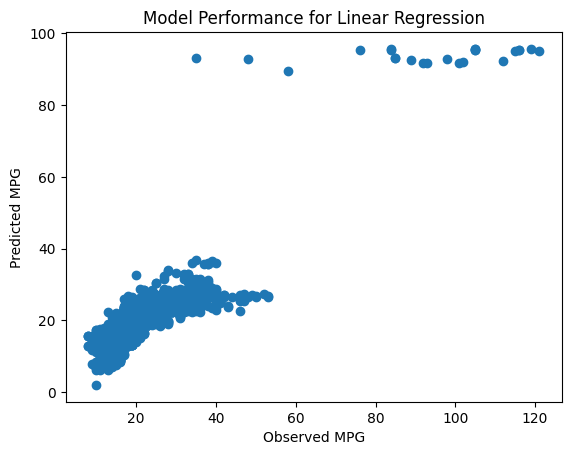

In [145]:
#plotting the performance
plt.scatter(y_test, y_predict)
plt.title('Model Performance for Linear Regression')
plt.xlabel('Observed MPG')
plt.ylabel('Predicted MPG')

In [146]:
# Evaluate the model
accuracy = r2_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.770358595936729


## 5-2- Random Forest

In [147]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_normalized, y_train)
y_predict = rf.predict(X_test_normalized)

Text(0, 0.5, 'Predicted MPG')

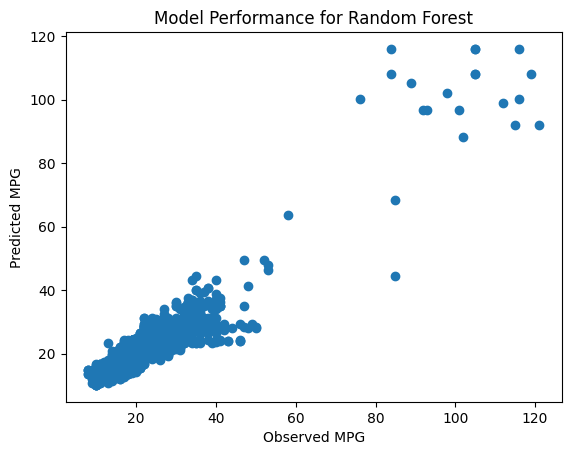

In [148]:
# Plotting the performance
plt.scatter(y_test, y_predict)
plt.title('Model Performance for Random Forest')
plt.xlabel('Observed MPG')
plt.ylabel('Predicted MPG')

In [149]:
# Evaluate the model
accuracy = r2_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8331416527413348


## 5-3- SVR

In [165]:
svr = SVR()
svr.fit(X_train_normalized, y_train)
y_predict = svr.predict(X_test_normalized)

Text(0, 0.5, 'Predicted MPG')

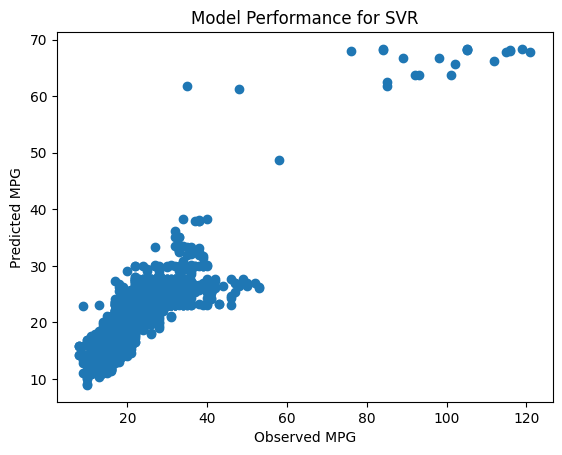

In [166]:
# Plotting the performance
plt.scatter(y_test, y_predict)
plt.title('Model Performance for SVR')
plt.xlabel('Observed MPG')
plt.ylabel('Predicted MPG')

In [152]:
# Evaluate the model
accuracy = r2_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7390226714888544


# 6- Results
***

Out of the three models tested for our anlayis, random forest had the best performance. The worst performance was for the SVR model. Linear model had performace between the two other models.

## 6-1- Hyper parameter tuning

Now that we have determined random forest as the best model, we can use grid search for hyper parameter tuning and improve our model.

In [153]:
from sklearn.model_selection import GridSearchCV

In [154]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features':['sqrt', 'log2', None],
    'max_depth':[3,6,9]
}
rf = RandomForestRegressor(random_state=0)

search = GridSearchCV(rf, param_grid, scoring='r2')


In [158]:
search.fit(X_train_normalized, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 500, 1000]},
             scoring='r2')

In [160]:
search.best_estimator_

RandomForestRegressor(max_depth=9, max_features=None, n_estimators=500,
                      random_state=0)

In [161]:
y_predict = clf.predict(X_test_normalized)

Text(0, 0.5, 'Predicted MPG')

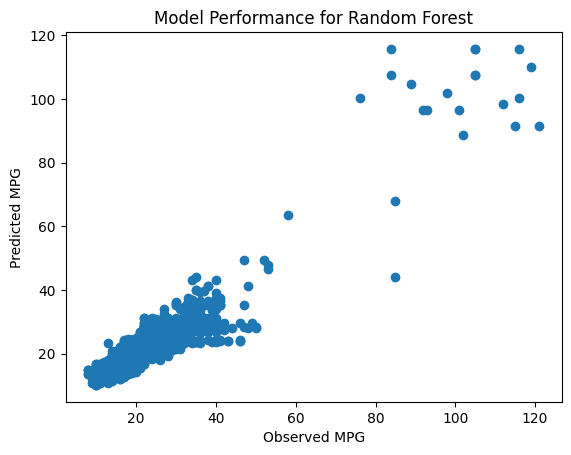

In [162]:
# Plotting the performance
plt.scatter(y_test, y_predict)
plt.title('Model Performance for Random Forest')
plt.xlabel('Observed MPG')
plt.ylabel('Predicted MPG')

In [163]:
# Evaluate the model
accuracy = r2_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8331964182519185


The results are only slightly better than the default parameters.

## 6-2- Feature Importance

A feature importance analysis shows us that the most important factors in the predicting the MPG.

In [164]:
feature_scores = pd.Series(clf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

Fuel Type_Electricity               0.471113
Engine Cylinders                    0.358092
Year                                0.091070
Drive_Front-Wheel Drive             0.048074
Fuel Type_Diesel                    0.016846
Drive_4-Wheel or All-Wheel Drive    0.004740
Fuel Type_Gas                       0.004523
Drive_Rear-Wheel Drive              0.002531
Fuel Type_Hybrid                    0.002321
Drive_2-Wheel Drive                 0.000508
Fuel Type_CNG                       0.000182
dtype: float64


As you can see the top 3 predictors are if the car is electric, number of cylinder, and year.

# 7- Conclusion
***
In this work we developed a model for MPG of a car based on year, fuel type, drivetrain, and number of cylinders. We tried three models for this purpose: linear regression, random forest, and support vector machines. The best-performing model was random forest, achieving a coefficient of determination (r2) of 0.83. Feature analysis of the model showed that the top three predictors for the MPG are whether the vehicle is electric, number of engine cylinders, and the year that the car is made.


# 8- Next Steps
- Evaluation Metric: r2 can be misleading for datasets with outliers. Since there are some very high MPG data points (electric cars), they can falsely improve the results of modeling. Other metrics (such as mean squared error, mean absolute error, etc.) can be explored for better analysis.
- Additional features can be added to the model to imporve the results.
- Additional models can be tested for this analysis.
- More feature analysis can be made for this analysis.